In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input

from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
#from mlxtend.plotting import plot_confusion_matrix
import random
from imblearn.over_sampling import RandomOverSampler
from generator import Generator

/home/lkgupta/my_project_dir/my_project_env/lib/python3.5/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/lkgupta/my_project_dir/my_project_env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/lkgupta/my_project_dir/my_project_env/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3750295353643749670
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4151085608118311424
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9816943017817129378
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 865414718960645699
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16630375005753664991
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16288298554859593140
physical_device_desc: "device: XLA_GPU device"
]
[]
2.3.1


## Reading Data 

In [3]:
labelsdf= pd.read_csv("worDwiseLabels/gt.csv")

In [4]:
labelsdf.head()

,File_name,Script,translation,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,word_1.png,Arabic,فروجنا,NaN,NaN,NaN,NaN
1,word_2.png,Arabic,المشوى,NaN,NaN,NaN,NaN
2,word_3.png,Arabic,حلال,NaN,NaN,NaN,NaN
3,word_4.png,Arabic,و,NaN,NaN,NaN,NaN
4,word_5.png,Arabic,طازج,NaN,NaN,NaN,NaN


In [5]:
(labelsdf['Script']).value_counts()

Latin       42629
Korean       4476
Japanese     4108
Arabic       3505
Bangla       3214
Chinese      2702
Symbols      1133
3               1
Name: Script, dtype: int64

In [6]:
def resize_image(img, min_side_len):
    max_side_len = 256
    h, w, c = img.shape

    # limit the min side maintaining the aspect ratio
    if max(h, w) > max_side_len:
        im_scale = float(max_side_len) / h if h > w else float(max_side_len) / w  
    else:
        im_scale = 1.

    new_h = int(h * im_scale)
    new_w = int(w * im_scale)

    re_im = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    
    h, w, c = re_im.shape
    
    if min(h, w) < min_side_len:
        im_scale = float(min_side_len) / h if h < w else float(min_side_len) / w           
    else:
        im_scale = 1.

    new_h = int(h * im_scale)
    new_w = int(w * im_scale)

    re_im2 = cv2.resize(re_im, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
        
        
    return re_im2  #, new_h / h, new_w / w

In [ ]:
min_side_len = 32

directory = 'wordWise_fcn4/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
for filename in os.listdir('wordWise'):
    
    img = cv2.imread(os.path.join('wordWise',filename))
    new_im=resize_image(img, min_side_len)
        
    path = directory + filename
    cv2.imwrite(path, new_im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [6]:
import cv2
import os

imageInfoDf= pd.DataFrame()

name=[]
height=[]
width=[]
depth=[]


def load_images_from_folder(folder):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            name.append(filename)
            width.append(img.shape[1])
            height.append(img.shape[0])
            depth.append(img.shape[2])

In [7]:
load_images_from_folder("wordWise_fcn4")

In [8]:
imageInfoDf['fileName']=name
imageInfoDf['height']=height
imageInfoDf['width']=width
imageInfoDf['depth']=depth

In [9]:
imageInfoDf['ratio']=imageInfoDf['width']/imageInfoDf['height']
imageInfoDf['logratio']=imageInfoDf['ratio'].apply(math.log)

Text(0, 0.5, 'Frequency')

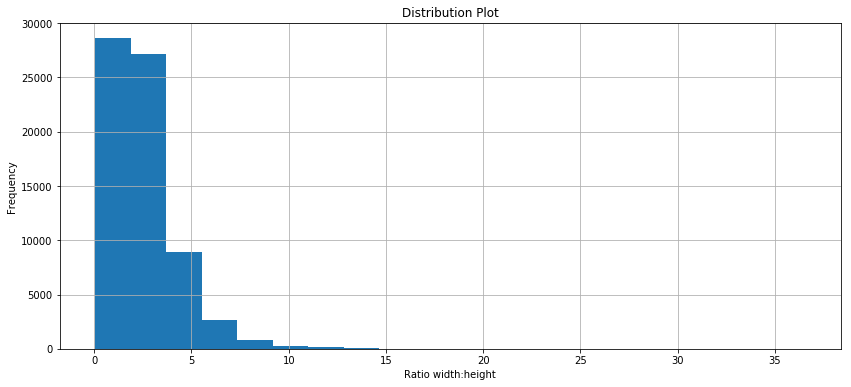

In [10]:
imageInfoDf['ratio'].hist(bins=20, figsize=[14,6])
plt.title('Distribution Plot')
plt.xlabel('Ratio width:height')
plt.ylabel('Frequency')

In [11]:
imageInfoDf.describe()

,height,width,depth,ratio,logratio
count,68613.000000,68613.000000,68613.0,68613.000000,68613.000000
mean,73.327547,153.601781,3.0,2.534334,0.709503
std,51.225192,87.320270,0.0,1.750891,0.700772
min,32.000000,32.000000,3.0,0.050794,-2.979984
25%,36.000000,72.000000,3.0,1.345133,0.296493
50%,57.000000,141.000000,3.0,2.156250,0.768371
75%,89.000000,256.000000,3.0,3.270833,1.185045
max,630.000000,1170.000000,3.0,36.562500,3.599023


In [ ]:
imageInfoDf['logratio'].hist(bins=20, figsize=[14,6])
plt.title('Distribution Plot')
plt.xlabel('Ratio width:height')
plt.ylabel('Frequency')

In [6]:
labelsdf = labelsdf.dropna(axis=0, subset=['Script'])
labelsdf = labelsdf.dropna(axis=0, subset=['File_name'])
labelsdf=labelsdf[(labelsdf['Script'] !='Symbols')]
labelsdf=labelsdf[(labelsdf['Script'] !='3')]

### Balancing the imbalanced data by assigning weights to classes

##### We did weights optimization of classes using inverse frequencies of classes. We will then pass these weights to cost function of the model

In [7]:
class_index={0:'Arabic',1:'Bangla', 2:'Chinese', 3:'Japanese', 4:'Korean',5:'Latin'}
#class_index={'Arabic': 0,'Bangla': 1,'Chinese': 2,'Japanese': 3,'Korean': 4,'Latin': 5}
total=labelsdf['Script'].value_counts().sum()
vc=labelsdf['Script'].value_counts()
class_weights={val:total/vc[class_index[val]]for val in class_index}
class_weights

{0: 17.29928673323823,
 1: 18.865588052271313,
 2: 22.440414507772022,
 3: 14.75998052580331,
 4: 13.546470062555853,
 5: 1.4223650566515753}

### Splitting data into Train, Test and Validation 

In [8]:
labelsdf_train_val = labelsdf.sample(frac = 0.85,random_state=12) 
labelsdf_test = labelsdf.drop(labelsdf_train_val.index)


labelsdf_train = labelsdf_train_val.sample(frac = 0.85,random_state=12) 
labelsdf_val = labelsdf_train_val.drop(labelsdf_train.index)

labelsdf_train = labelsdf_train.reset_index()


In [9]:
(labelsdf_val['Script']).value_counts()

Latin       5389
Korean       606
Japanese     535
Bangla       435
Arabic       434
Chinese      332
Name: Script, dtype: int64

In [10]:
(labelsdf_test['Script']).value_counts()

Latin       6456
Korean       626
Japanese     593
Arabic       543
Bangla       458
Chinese      419
Name: Script, dtype: int64

In [11]:
(labelsdf_train['Script']).value_counts()

Latin       30784
Korean       3244
Japanese     2980
Arabic       2528
Bangla       2321
Chinese      1951
Name: Script, dtype: int64

## Generating Train, Test and Validation Iterator using Keras ImageDataGenerator 

* We have to create a custom image generator for this case as ImageGenerator of Keras use images with fixed dimentions

In [49]:
imageDir = 'wordWise_fcn4/'
    
# If you get out of memory error try reducing the batch size
BATCH_SIZE=16

train_it = Generator( imageDir,labelsdf_train,'File_name','Script', BATCH_SIZE=16, shuffle_images=True, image_min_side=32)
val_it = Generator( imageDir,labelsdf_val,'File_name','Script', BATCH_SIZE=16, shuffle_images=True, image_min_side=32)
test_it = Generator( imageDir,labelsdf_test,'File_name','Script', BATCH_SIZE=16, shuffle_images=True, image_min_side=32)

In [15]:
def FCN_model(len_classes=6, dropout_rate=0.2):
    
    input = tf.keras.layers.Input(shape=(None, None, 3))

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(input)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)


    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)


    x = tf.keras.layers.Conv2D(filters=64, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

 
    x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=predictions)
    
    print(model.summary())
    #print(f'Total number of layers: {len(model.layers)}')

    return model

In [16]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [17]:
with strategy.scope():
    fcn_model=FCN_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
dropout (Dropout)            (None, None, None, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 32)    128       
_________________________________________________________________
activation (Activation)      (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   36992     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 128)  

In [18]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001)
fcn_model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['Recall','Precision','Accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
checkpoint = ModelCheckpoint('fcnModel7.h5',save_best_only=True,monitor='val_loss')
historyInc = fcn_model.fit_generator(generator=train_it,steps_per_epoch=len(train_it), 
                              validation_data=val_it, validation_steps=len(val_it),
                              epochs=5,callbacks=[es,checkpoint])

Epoch 1/5
2790/2790 [==============================] - 11016s 4s/step - loss: 1.0342 - precision: 0.6931 - recall: 0.6914 - accuracy: 0.0000e+00 - val_recall: 0.6803 - val_loss: 1.0621 - val_accuracy: 0.0000e+00 - val_precision: 0.7061
Epoch 2/5
1385/2790 [=============>................] - ETA: 1:30:14 - loss: 1.0241 - precision: 0.6955 - recall: 0.6890 - accuracy: 0.0000e+00

In [68]:
fcn_model = keras.models.load_model("fcnModel7.h5")

In [14]:
score = fcn_model.evaluate_generator(test_it)

#Confution Matrix and Classification Report
#Y_predFCN = fcn_model.predict(test_it) 
#Y_predFCN = np.argmax(Y_predFCN, axis=1)


Instructions for updating:
Please use Model.evaluate, which supports generators.


In [15]:
print('Test loss:', score[0])
print('Test recall:', score[1])
print('Test precision:', score[2])
print('Test accuracy:', score[3])
print(score)


Test loss: 1.057421326637268
Test recall: 0.7090290188789368
Test precision: 0.7109031081199646
Test accuracy: 0.0
[1.057421326637268, 0.7090290188789368, 0.7109031081199646, 0.0]


In [69]:
Y_predFCN = fcn_model.predict(test_it)

In [70]:
y_predFCN = np.argmax(Y_predFCN, axis=1)

In [71]:
actualClass=[]
for i in range (569):
    for j in range (16):
        actualClass.append(np.argmax(test_it.__getitem__(i)[1][j]))
        


In [72]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,precision_recall_fscore_support

In [81]:
def samplesMetrics(classes, y_pred, nSamples=30):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    allPredictions = pd.DataFrame(list(zip(classes, y_pred)), columns=['Classes', 'yPredicted'])

    for i in range(nSamples):

        labelsdf_Samples= allPredictions.sample(n=500)
        #print(labelsdf_Samples)

        accuracy = accuracy_score(labelsdf_Samples['Classes'],labelsdf_Samples['yPredicted'])
        accuracies.append(accuracy)
        #print(accuracy)

        metrics = precision_recall_fscore_support(labelsdf_Samples['Classes'],labelsdf_Samples['yPredicted'],average='weighted')
        precisions.append(metrics[0])
        recalls.append(metrics[1])
        f1_scores.append(metrics[2])

    metricsEvaluated = {'Accuracy': accuracies,'Precision': precisions,'Recall': recalls, 'F1-Score': f1_scores}
    metricsDf = pd.DataFrame(metricsEvaluated)
    return metricsDf


def samplesMetricsFromModel(model,test_it):
    Y_pred = model.predict_generator(test_it) 
    y_pred = np.argmax(Y_pred, axis=1)
    metricsDf= samplesMetrics(test_it.classes, y_pred, nSamples=30)
    return  metricsDf

In [82]:
  
metricsDf = samplesMetrics(actualClass,y_predFCN)


metricsDf.to_csv("FCN.csv")


metricsDf

,Accuracy,F1-Score,Precision,Recall
0,0.700,0.576471,0.490000,0.700
1,0.712,0.592224,0.506944,0.712
2,0.658,0.522273,0.432964,0.658
3,0.746,0.637475,0.556516,0.746
4,0.694,0.568638,0.481636,0.694
5,0.678,0.547895,0.459684,0.678
6,0.720,0.602791,0.518400,0.720
7,0.698,0.573856,0.487204,0.698
8,0.678,0.547895,0.459684,0.678
9,0.712,0.592224,0.506944,0.712


In [78]:
avgAcc=np.mean(metricsDf['Accuracy'])
avgAcc

0.7083333333333334

In [83]:
avgRecall=np.mean(metricsDf['Recall'])
avgRecall

0.7070000000000001

In [84]:
avgPrecision=np.mean(metricsDf['Precision'])
avgPrecision

0.5002262666666667

In [60]:
avg=np.mean(metricsDf['F1-Score'])
std=np.std(metricsDf['F1-Score'])
print("mean= ",avg)
print("std= ",std)

mean=  0.581473875032474
std=  0.029190625268758912
